### Classificando problemas ortopédicos

Esse dataset contém dados sobre problemas ortopédicos na coluna vertebral, diagnosticados no Centre Médico-Chirurgical de Réadaptation des Massues, em Lyon, France. Contém 6 atributos biomecânicos para 310 entradas **anonimizadas**, sendo **100** de pacientes considerados sem problemas **(Normal - NO)**, **60** de pacientes com **Hérnia de Disco (Disk Hernia - DH)** e **150** de pacientes com Espondilolistese **(Spondylolisthesis - SL)**. 

O dataset está disponível em https://www.openml.org/d/1523


# Passo 1: Carregar a base de dados

In [31]:
!curl -L -o ~/Downloads/vertebralcolumndataset.zip https://www.kaggle.com/api/v1/datasets/download/jessanrod3/vertebralcolumndataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11826  100 11826    0     0  13658      0 --:--:-- --:--:-- --:--:-- 56314


In [32]:
!unzip -o ~/Downloads/vertebralcolumndataset.zip -d .
!ls *.csv


Archive:  /home/lucas/Downloads/vertebralcolumndataset.zip
  inflating: ./Dataset_spine.csv     
Dataset_spine.csv


In [33]:
import pandas as pd                       
import matplotlib.pyplot as plt           
import seaborn as sns                    
import numpy as np                        

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, cohen_kappa_score                      
from sklearn.preprocessing import StandardScaler, MinMaxScaler          
import zipfile
import os

tabela_dados = pd.read_csv('Dataset_spine.csv')
tabela_dados.head()
tabela_dados.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'Diagnostic']
tabela_dados.head()

,V1,V2,V3,V4,V5,V6,Diagnostic
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [34]:
tabela_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   V1          310 non-null    float64
 1   V2          310 non-null    float64
 2   V3          310 non-null    float64
 3   V4          310 non-null    float64
 4   V5          310 non-null    float64
 5   V6          310 non-null    float64
 6   Diagnostic  310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [35]:
# Removendo o outlier:
tabela_dados.drop(tabela_dados.loc[tabela_dados['V6'] > 400].index, inplace=True)
tabela_dados.loc[tabela_dados['V6'] > 400]

# Separação dos dados
x = tabela_dados.drop(columns=['Diagnostic'])
y = tabela_dados['Diagnostic'] #O que eu quero prever. (Target)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42) 

# Normalizando os dados
#scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)
scaler = MinMaxScaler() #chamando o metodo de normalização dos dados (0-1)
scaler.fit(x_train)# qual média e std será utilizado para o escalonamento
x_train_scaled = scaler.transform(x_train)
x_test_scaled= scaler.transform(x_test)

# Criação do modelo
# Treinando o modelo com dados sem escalonamento:
modelo_classificador = KNeighborsClassifier(n_neighbors=3)
modelo_classificador.fit(x_train_scaled, y_train) 


KNeighborsClassifier(n_neighbors=3)

In [37]:

# Validação do modelo (testando o modelo)
# Predição sem escalolnamento
y_predito = modelo_classificador.predict(x_test_scaled)
tabela_dados.groupby('Diagnostic').count()

,V1,V2,V3,V4,V5,V6
Diagnostic,,,,,,
Abnormal,209,209,209,209,209,209
Normal,100,100,100,100,100,100


<Figure size 1500x500 with 0 Axes>

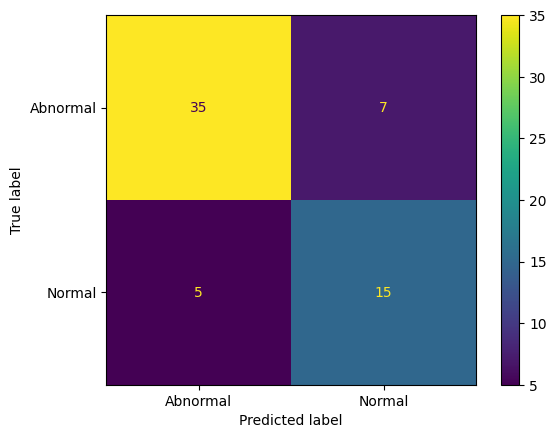

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_true = y_test,
                                   y_pred = y_predito,
                                   labels=['Abnormal', 'Normal'])

# plotando uma figura com a matriz de confusao
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao,
                              display_labels=['Abnormal', 'Normal'])
disp.plot(values_format='d') 

In [41]:
print(classification_report(y_test, y_predito))

              precision    recall  f1-score   support

    Abnormal       0.88      0.83      0.85        42
      Normal       0.68      0.75      0.71        20

    accuracy                           0.81        62
   macro avg       0.78      0.79      0.78        62
weighted avg       0.81      0.81      0.81        62



### Testando o KNN com validação cruzada:
### Incluindo a etapa de validação do modelo de knn:

Estamos fazendo a VALIDAÇÃO dos melhores hiperparâmetros do modelo de ML:

Idealmente, devemos ter 5 conjuntos de dados (treino, teste, validacao) ou usar a validação cruzada em cima dos dados de treino.

In [42]:
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 

kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) os dados.
result = cross_val_score(modelo_classificador, x, y, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))

K-Fold (R^2) Scores: [0.82258065 0.77419355 0.75806452 0.83870968 0.83606557]
Mean R^2 for Cross-Validation K-Fold: 0.8059227921734532


A saída exibirá a precisão média do modelo (ou seja, a acurácia) com uma medida de variação associada (calculada pela multiplicação do desvio padrão por 2). 
Escolhendo os melhores hiperparâmetros com validação cruzada:

Text(0, 0.5, 'Mean Error')

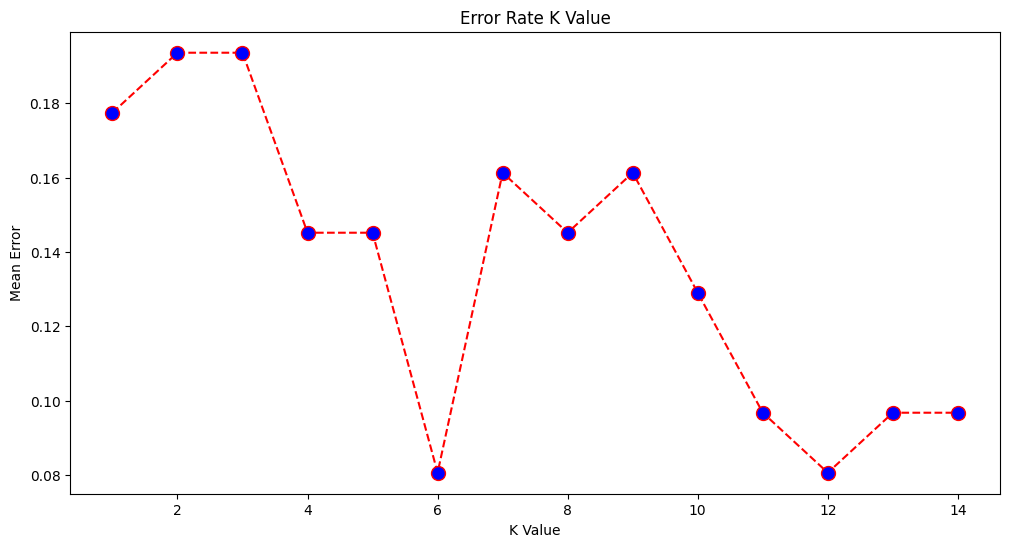

In [44]:
from sklearn.model_selection import GridSearchCV #metodo para seleção dos melhores Ks (#Basicamente a busca por força bruta)
from sklearn.metrics import make_scorer, accuracy_score, f1_score #métricas de validação
import numpy as np
import matplotlib.pyplot as plt

error = [] #armazenar os erros

# Calculating error for K values between 1 and 15
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_scaled, y_train)
    pred_i = knn.predict(x_test_scaled)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [49]:
# Buscar os melhores parâmetros
# Vamos usar uma técnica chamada Gridsearch que é basicamente a busca por força bruta
# Iremos utilizar a técnica de validação cruzada de 5 folds (divisões) em cima do conjunto de treinamento
# Como métrica de melhor desemepnho usaremos a acurácia, isto é, estamos buscando os hiperparâmetros que maximizam a acurácia

# Parâmetros testados
param_grid = {'n_neighbors':[6,12], #total de vizinhos
              'weights': ['uniform', 'distance'], #Função de peso usada na previsão
              'metric':['cosine', 'euclidean', 'manhattan'] #métrica para cálculo da distância
             }

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(), 
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) #cv = gerador de validação cruzada / n_jobs = determina a quantidade de jobs processados

grid.fit(x_train_scaled, y_train) #Selecionando os melhores hiperparametros com base nos dados de treino
knn_params = grid.best_params_
print('KNN', knn_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END metric=cosine, n_neighbors=6, weights=uniform;, score=0.760 total time=   0.0s
[CV 4/5] END metric=cosine, n_neighbors=6, weights=uniform;, score=0.857 total time=   0.0s
[CV 2/5] END metric=cosine, n_neighbors=6, weights=uniform;, score=0.860 total time=   0.0s
[CV 3/5] END metric=cosine, n_neighbors=6, weights=uniform;, score=0.755 total time=   0.0s
[CV 5/5] END metric=cosine, n_neighbors=6, weights=uniform;, score=0.857 total time=   0.0s
[CV 1/5] END metric=cosine, n_neighbors=6, weights=distance;, score=0.780 total time=   0.0s
[CV 4/5] END metric=cosine, n_neighbors=6, weights=distance;, score=0.857 total time=   0.0s
[CV 2/5] END metric=cosine, n_neighbors=6, weights=distance;, score=0.840 total time=   0.0s
[CV 3/5] END metric=cosine, n_neighbors=6, weights=distance;, score=0.776 total time=   0.0s
[CV 5/5] END metric=cosine, n_neighbors=6, weights=distance;, score=0.878 total time=   0.0s
[CV 2/5] END m

In [50]:
grid.cv_results_ #analisando todos os possíveis testes

{'mean_fit_time': array([0.00288291, 0.00294533, 0.00299616, 0.00196176, 0.00219574,
        0.00191317, 0.00160532, 0.00115261, 0.00092483, 0.00086527,
        0.00084562, 0.0011498 ]),
 'std_fit_time': array([4.66303185e-04, 7.20200937e-04, 7.86397528e-04, 2.58437223e-04,
        1.28093283e-04, 6.77576921e-04, 1.84107463e-04, 3.65690101e-04,
        6.83914821e-05, 7.29241956e-05, 3.46383387e-05, 2.90319695e-04]),
 'mean_score_time': array([0.01328812, 0.00736041, 0.01328244, 0.00430017, 0.00608706,
        0.00241199, 0.00640926, 0.00152221, 0.0027318 , 0.00123482,
        0.00259037, 0.00169458]),
 'std_score_time': array([4.65463197e-03, 2.25092978e-03, 4.67806778e-03, 4.24074944e-04,
        5.90025340e-04, 9.38518589e-04, 4.78401565e-04, 4.90971591e-04,
        1.70482655e-04, 8.36096123e-05, 7.02420788e-05, 4.49375715e-04]),
 'param_metric': masked_array(data=['cosine', 'cosine', 'cosine', 'cosine', 'euclidean',
                    'euclidean', 'euclidean', 'euclidean', 'manha

### Testando vários tipos de algoritmos de classificação:

In [52]:
def AplicaValidacaoCruzada(x_axis, y_axis):
  # Linear Models.
  from sklearn.neighbors import KNeighborsClassifier  # k-vizinhos mais próximos (KNN)
  from sklearn.ensemble import RandomForestClassifier # RandomForest
  from sklearn.svm import SVC                         # Maquina de Vetor Suporte SVM

  # Cross-Validation models.
  from sklearn.model_selection import cross_val_score
  from sklearn.model_selection import KFold

  # Configuração de KFold.
  kfold  = KFold(n_splits=10, shuffle=True) 

  # Axis
  x = x_axis
  y = y_axis

  # Criando os modelos

  # KNN
  knn = KNeighborsClassifier(n_neighbors=6, metric= 'euclidean', weights='distance') 
  knn.fit(x, y) 

  # SVM
  svm = SVC()
  svm.fit(x, y)

  # RandomForest
  rf = RandomForestClassifier(random_state=7) 
  rf.fit(x, y) 

  # Applyes KFold to models.
  knn_result = cross_val_score(knn, x, y, cv = kfold)
  svm_result = cross_val_score(svm, x, y, cv = kfold)
  rf_result = cross_val_score(rf, x, y, cv = kfold)

  # Creates a dictionary to store Linear Models.
  dic_models = {
    "KNN": knn_result.mean(),
    "SVM": svm_result.mean(),
    "RF": rf_result.mean()
  }
  # Select the best model.
  melhorModelo = max(dic_models, key=dic_models.get)

  print("KNN (R^2): {0}\nSVM (R^2): {1}\nRandom Forest (R^2): {2}".format(knn_result.mean(), svm_result.mean(), rf_result.mean()))
  print("O melhor modelo é : {0} com o valor: {1}".format(melhorModelo, dic_models[melhorModelo]))


AplicaValidacaoCruzada(x, y)

KNN (R^2): 0.8382795698924731
SVM (R^2): 0.8480645161290322
Random Forest (R^2): 0.8250537634408601
O melhor modelo é : SVM com o valor: 0.8480645161290322
